# **Grammar Scoring Engine - SHL Kaggle Competition**

**Created by Sauhandikaa S.**

This notebook is created as part of the **SHL Hiring Assessment Challenge**. The objective is to build a grammar scoring engine for spoken audio files, using the provided WAV dataset and corresponding Likert-based MOS grammar scores.

### **Step 1: Set Up Environment and Install Dependencies**

This step involves setting up the working environment by installing the necessary libraries required for processing audio data, performing feature extraction, and building the machine learning model.

**Required Libraries:**

- **Librosa**: For audio feature extraction (e.g., MFCCs)  
- **NumPy**: For array manipulation and mathematical operations  
- **Pandas**: For loading and managing CSV data  
- **Matplotlib / Seaborn**: For data visualization and performance analysis  
- **Scikit-learn**: For machine learning models and evaluation metrics   
- **Soundfile**: For reading and writing `.wav` audio files  
- **SciPy**: For additional signal processing utilities  
- **TQDM**: For displaying progress bars during lengthy operations  
- **Pydub**: For basic audio operations such as cutting and concatenating  

**Installation Command:**

Use the following command to install all required dependencies:


In [1]:
!pip install librosa numpy pandas matplotlib seaborn scikit-learn tensorflow soundfile scipy tqdm pydub


**Verify Installation:**
After installation, check if everything is set up by importing the libraries:

In [2]:
import librosa
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import soundfile as sf
import scipy
import tqdm
import pydub
import os

### **Step 2: Load and Inspect Dataset**

**Objective:**  
This step involves loading the training metadata (`train.csv`) which contains audio filenames and their corresponding grammar scores (ranging from 0 to 5). A validation check is also performed to ensure the referenced audio files exist in the dataset directory.

**Tasks Performed:**

- **Load CSV File:**  
  The `train.csv` file is loaded using `pandas`. It contains two columns: `filename` and `label`.

- **Data Preview:**  
  The first few rows of the dataset are displayed using `train_df.head()` to verify successful loading.

- **Audio File Validation:**  
  A file existence check is performed for each entry in the dataset using `os.path.exists()` to confirm that all audio files listed in the CSV are present in the `/audios/train/` directory.

This validation step is essential before proceeding to feature extraction.


In [3]:
from google.colab import drive

# Mount Google Drive to access your dataset
drive.mount('/content/drive')

# Define the correct path to the training audio files (inside the 'train' subfolder)
train_audio_folder_path = '/content/drive/My Drive/Grammar_scoring_engine/Dataset/audios/train/'

# Load the CSV containing training data
train_df = pd.read_csv('/content/drive/My Drive/Grammar_scoring_engine/Dataset/train.csv')

# Check if audio files exist in the provided train folder
train_df['audio_exists'] = train_df['filename'].apply(lambda x: os.path.exists(os.path.join(train_audio_folder_path, x)))

# Display the first few rows to verify everything is working
train_df.head()


Mounted at /content/drive


,filename,label,audio_exists
0,audio_710.wav,1.0,True
1,audio_1265.wav,1.0,True
2,audio_1114.wav,1.5,True
3,audio_946.wav,1.5,True
4,audio_1127.wav,2.0,True


### **Step 3: Extract Features from Audio**

**Objective:**  
To transform raw `.wav` audio files into structured numerical representations by extracting relevant audio features. These features are essential for enabling the model to assess grammar quality in spoken language.

**Rationale:**  
Machine learning models are unable to process raw audio directly. Therefore, it is necessary to extract descriptive features that capture the characteristics of each audio signal.

**Extracted Features:**

- **Duration:** Total length of the audio file  
- **Zero Crossing Rate:** Frequency at which the audio signal changes sign  
- **Spectral Centroid:** Indicates the brightness of the sound  
- **Spectral Bandwidth:** Measures the range of frequencies present  
- **RMS Energy:** Represents the signal's overall energy  
- **MFCCs (Mel-Frequency Cepstral Coefficients):** Captures timbral features of the audio, designed to reflect human hearing

These features serve as input to the machine learning model.


In [22]:
from tqdm import tqdm

# Path to training audio folder (Adjust if required)
audio_folder_path = '/content/drive/My Drive/Grammar_scoring_engine/Dataset/audios/train/'

# Function to extract features from an audio file
def extract_features(file_path):
    try:
        y, sr = librosa.load(file_path, sr=None)  # Load audio with original sampling rate

        # Feature extraction
        duration = librosa.get_duration(y=y, sr=sr)
        zcr = np.mean(librosa.feature.zero_crossing_rate(y))
        centroid = np.mean(librosa.feature.spectral_centroid(y=y, sr=sr))
        bandwidth = np.mean(librosa.feature.spectral_bandwidth(y=y, sr=sr))
        rms = np.mean(librosa.feature.rms(y=y))

        mfccs = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=13)
        mfccs_mean = np.mean(mfccs, axis=1)  # 13 MFCC values

        # Combine all features into one vector
        features = [duration, zcr, centroid, bandwidth, rms] + list(mfccs_mean)
        return features

    except Exception as e:
        print(f"Error processing {file_path}: {e}")
        return [np.nan] * 18  # return empty values if something goes wrong

# Extract features for each file in training data
feature_list = []
print("Extracting features from training audio...")

for fname in tqdm(train_df['filename']):
    file_path = os.path.join(audio_folder_path, fname)
    features = extract_features(file_path)
    feature_list.append(features)

# Convert to DataFrame
feature_names = ['duration', 'zcr', 'centroid', 'bandwidth', 'rms'] + [f'mfcc_{i+1}' for i in range(13)]
features_df = pd.DataFrame(feature_list, columns=feature_names)

# Concatenate with original DataFrame (which contains labels)
train_features = pd.concat([train_df[['filename', 'label']], features_df], axis=1)

# Preview final feature DataFrame
train_features.head()

Extracting features from training audio...


100%|██████████| 444/444 [02:53<00:00,  2.57it/s]


,filename,label,duration,zcr,centroid,bandwidth,rms,mfcc_1,mfcc_2,mfcc_3,mfcc_4,mfcc_5,mfcc_6,mfcc_7,mfcc_8,mfcc_9,mfcc_10,mfcc_11,mfcc_12,mfcc_13
0,audio_710.wav,1.0,60.074688,0.150859,1652.834782,1421.570396,0.031372,-340.821472,87.854080,-27.584362,20.225647,9.789281,-6.006240,-1.812913,-4.854423,-6.230354,-9.591331,-7.490045,-0.094280,1.480482
1,audio_1265.wav,1.0,60.074688,0.143139,1812.681453,1710.677609,0.015064,-485.992737,50.111820,8.837244,9.500427,1.973223,2.533967,-6.811783,1.587861,-4.828947,-3.566349,-2.680598,-2.683721,-2.376489
2,audio_1114.wav,1.5,60.074688,0.132682,2126.143258,1593.561943,0.021168,-468.621979,55.773441,-6.867956,12.415868,2.657126,-3.901442,-1.949762,-3.627633,-3.994594,0.676666,-5.172699,-3.183967,-2.695612
3,audio_946.wav,1.5,60.074688,0.105385,1962.232377,1590.935140,0.037655,-418.862366,24.498125,0.983082,3.577540,-11.690801,-2.484139,-9.580399,-0.941148,-7.578836,1.941514,-4.787622,-2.934152,-6.141343
4,audio_1127.wav,2.0,60.074688,0.155081,1751.896485,1533.526463,0.049667,-339.085052,81.655800,0.515613,23.920927,9.947325,-3.167432,-4.842579,-13.521027,-12.038767,-7.997025,-7.924070,-5.072709,5.689839


### **Step 4: Visualize and Analyze Features**

**Objective**: This step focuses on visualizing the extracted audio features and understanding their relationship with the grammar scores. The primary goal is to identify which features might be valuable for the predictive model.

**1. Correlation Heatmap**
We begin by visualizing the correlation matrix of the extracted features with the grammar scores. This helps us identify which features are strongly correlated with the target variable and may contribute significantly to our model.

**2. Distribution Plots**
Next, we examine the distributions of individual features, such as Zero Crossing Rate (ZCR), Spectral Centroid, and Mel-frequency cepstral coefficients (MFCCs). This helps us identify any skewness or outliers in the features.

**3. Feature vs Label Scatter Plots**
We explore how each feature (e.g., ZCR, MFCCs) correlates with the grammar score (`label`). Scatter plots help us visualize any linear or non-linear relationship between individual features and the grammar score.

These visualizations give us critical insights into which features may be more informative when building the prediction model.


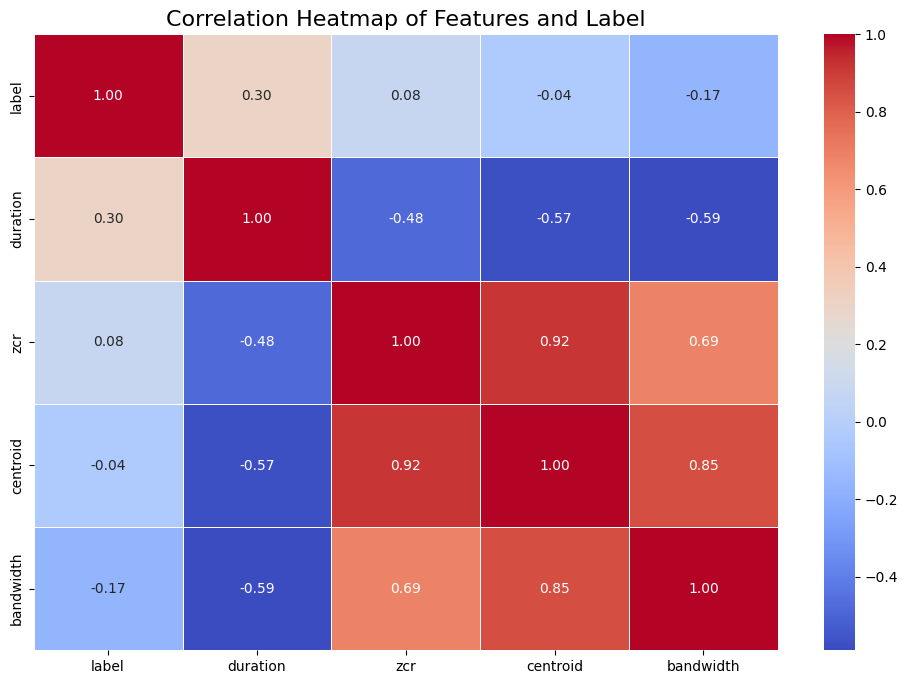

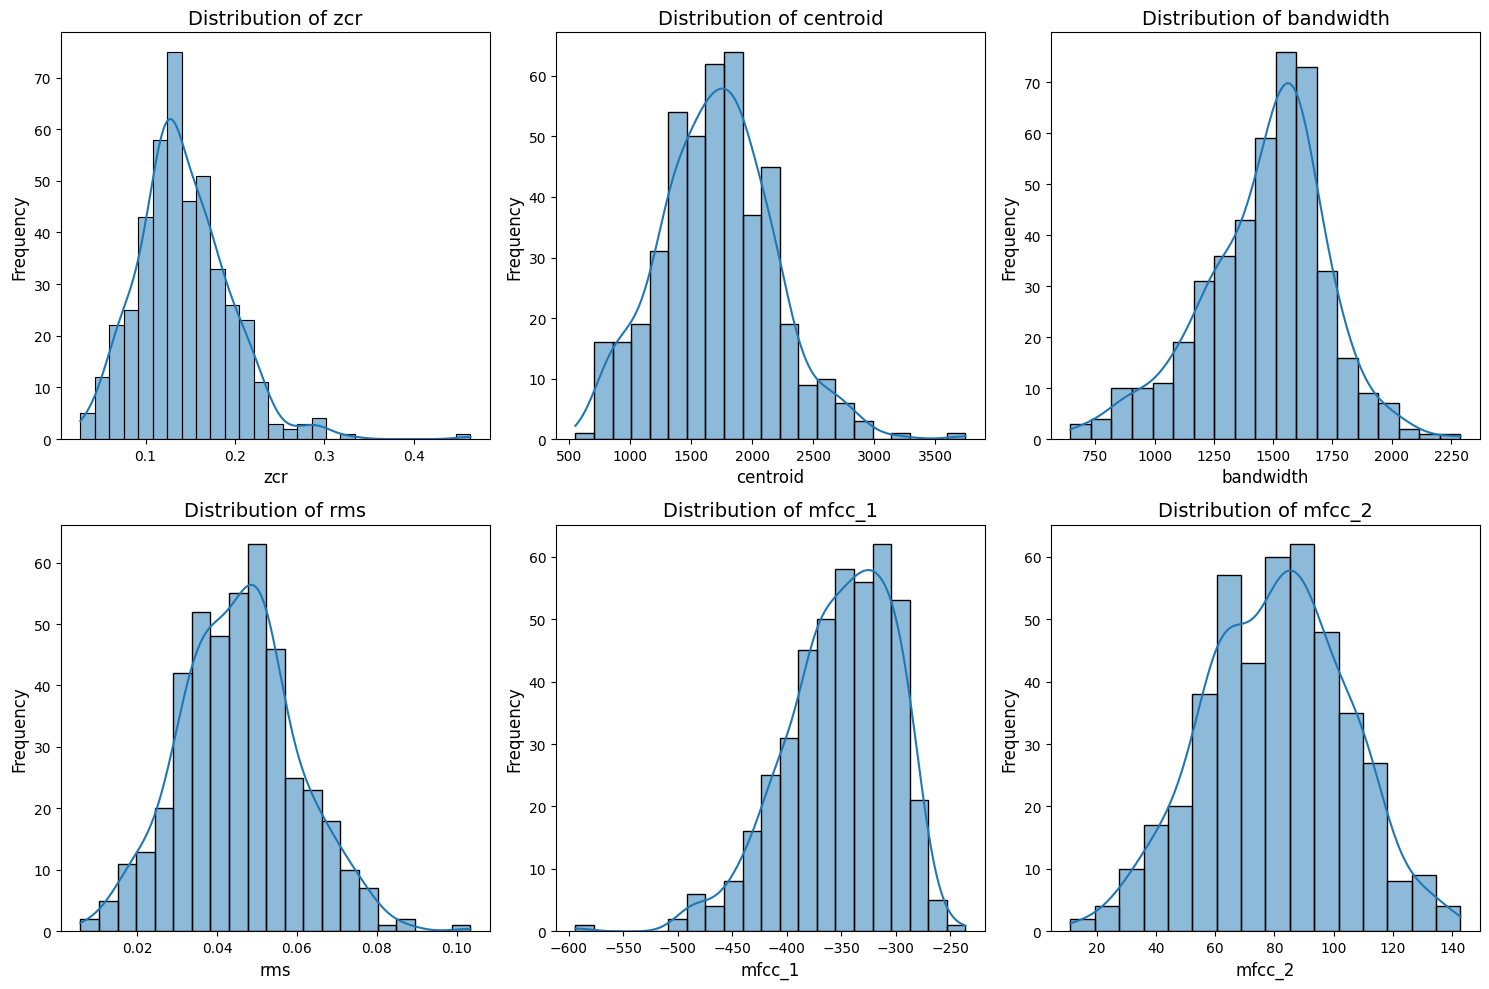

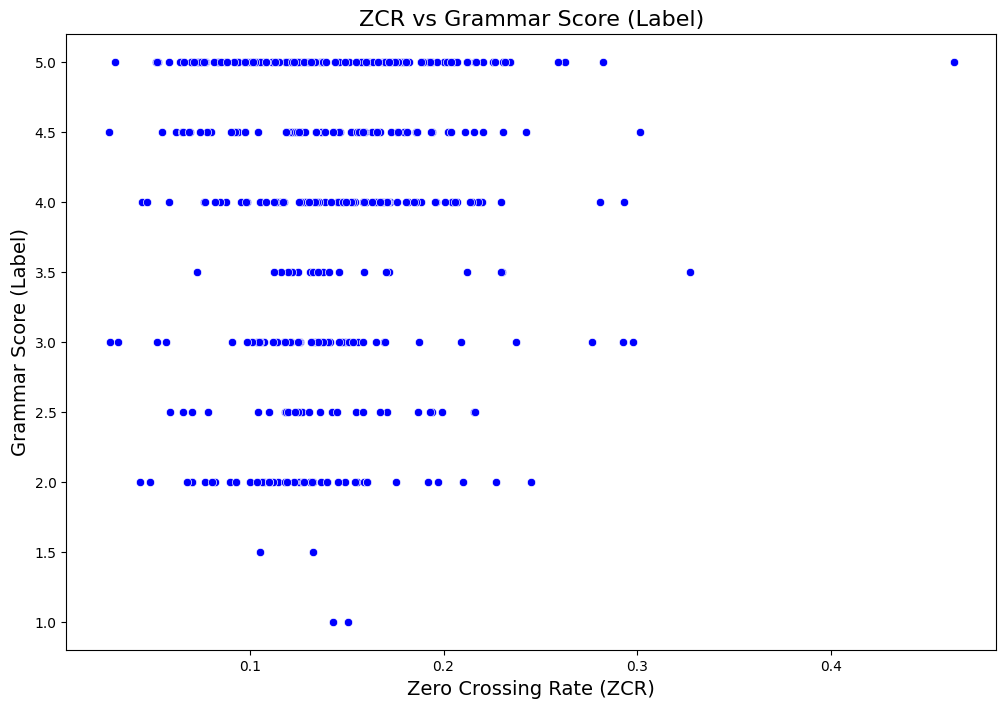

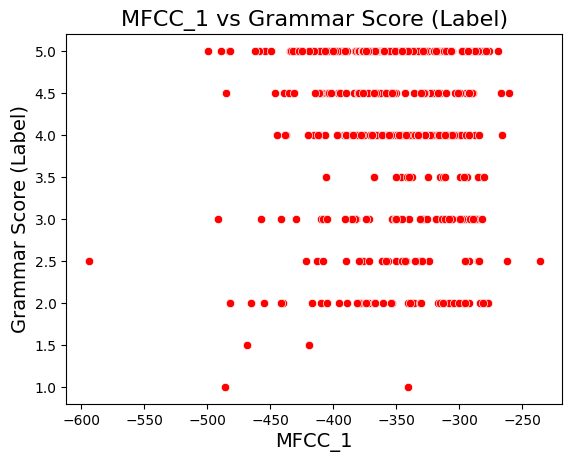

In [23]:
import seaborn as sns
import matplotlib.pyplot as plt

# Exclude non-numeric columns (like 'filename') from the features dataframe
numeric_features = train_features.select_dtypes(include=['float64', 'int64'])

# Set up the figure for the correlation heatmap
plt.figure(figsize=(12, 8))

# Correlation heatmap for features and the label (target variable)
corr_matrix = numeric_features.corr()  # Compute correlation matrix
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
plt.title("Correlation Heatmap of Features and Label", fontsize=16)
plt.show()

# Distribution plot for key features (e.g., MFCCs, ZCR, RMS)
fig, axes = plt.subplots(2, 3, figsize=(15, 10))

# List of features to plot
features = ['zcr', 'centroid', 'bandwidth', 'rms', 'mfcc_1', 'mfcc_2']

# Plot distribution for each feature
for i, feature in enumerate(features):
    sns.histplot(train_features[feature], kde=True, ax=axes[i//3, i%3])
    axes[i//3, i%3].set_title(f"Distribution of {feature}", fontsize=14)
    axes[i//3, i%3].set_xlabel(feature, fontsize=12)
    axes[i//3, i%3].set_ylabel("Frequency", fontsize=12)

plt.tight_layout()
plt.show()

# Scatter plot to analyze the relationship between feature and target label
plt.figure(figsize=(12, 8))

# Plot ZCR vs Label
sns.scatterplot(x=train_features['zcr'], y=train_df['label'], color='blue')
plt.title('ZCR vs Grammar Score (Label)', fontsize=16)
plt.xlabel('Zero Crossing Rate (ZCR)', fontsize=14)
plt.ylabel('Grammar Score (Label)', fontsize=14)
plt.show()

# Similarly, plot other features vs label
sns.scatterplot(x=train_features['mfcc_1'], y=train_df['label'], color='red')
plt.title('MFCC_1 vs Grammar Score (Label)', fontsize=16)
plt.xlabel('MFCC_1', fontsize=14)
plt.ylabel('Grammar Score (Label)', fontsize=14)
plt.show()


In [20]:
print(numeric_features.columns)

Index(['label', 'duration', 'zcr', 'centroid', 'bandwidth'], dtype='object')


### **Step 5: Model Building and Evaluation**

This step involves using the extracted audio features to train a model that can predict the grammar score (`label`) associated with each audio file.

**Objective:**

- Train a machine learning model using the extracted features  
- Evaluate the model’s performance using appropriate regression metrics such as Mean Squared Error (MSE) and Root Mean Squared Error (RMSE)

**Procedure:**

1. **Preprocessing:**  
   The training data is prepared by separating the features from the target variable (`label`).

2. **Model Selection:**  
   A basic regression model is selected for initial experimentation. Options include:
   - Linear Regression  
   - Random Forest Regressor

3. **Model Training:**  
   The selected model is trained using the feature set and corresponding grammar scores.

4. **Model Evaluation:**  
   The model's performance is assessed using evaluation metrics such as RMSE to determine the accuracy of the predictions and guide further tuning or model selection.


In [25]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
import numpy as np

# Step 1: Prepare the features and target (label)
# Correctly select features from the train_features DataFrame
feature_columns = [col for col in train_features.columns if col not in ['filename', 'label']]
X = train_features[feature_columns]
y = train_features['label']  # Target variable (label)

# Step 2: Split the data into training and testing sets (80-20 split)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Step 3: Train a model (Random Forest or Linear Regression)
# Random Forest Regressor
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

# Step 4: Evaluate the model
y_pred = rf_model.predict(X_test)

# Calculate RMSE (Root Mean Squared Error)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))

print(f"RMSE for Random Forest Regressor (after correcting features): {rmse}")

# Optionally, you can also try Linear Regression
lr_model = LinearRegression()
lr_model.fit(X_train, y_train)
y_pred_lr = lr_model.predict(X_test)

# Calculate RMSE for Linear Regression
rmse_lr = np.sqrt(mean_squared_error(y_test, y_pred_lr))
print(f"RMSE for Linear Regression (after correcting features): {rmse_lr}")



RMSE for Random Forest Regressor (after correcting features): 0.9360096393434313
RMSE for Linear Regression (after correcting features): 1.0261742583573947


### ***Model Improvement: Hyperparameter Tuning for Random Forest***

**Objective**  
The goal of this step is to enhance the performance of the Random Forest model by fine-tuning its hyperparameters using `GridSearchCV`.

**Process:**

- A **grid search** was conducted across several hyperparameters, including:
  - `n_estimators`: The number of trees in the forest
  - `max_depth`: The maximum depth of each tree
  - `min_samples_split`: The minimum number of samples required to split an internal node
  - `min_samples_leaf`: The minimum number of samples required to be at a leaf node
  - `bootstrap`: Whether bootstrap samples are used when building trees

- **3-fold cross-validation** was utilized to evaluate model performance during the grid search process.

**Best Hyperparameters Identified:**
```python
{
  'bootstrap': True,
  'max_depth': None,
  'min_samples_leaf': 1,
  'min_samples_split': 2,
  'n_estimators': 200
}


In [26]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV

# Define the Random Forest model
rf = RandomForestRegressor()

# Define the hyperparameters grid
param_grid = {
    'n_estimators': [100, 200, 300],  # Number of trees in the forest
    'max_depth': [None, 10, 20, 30],  # Maximum depth of the trees
    'min_samples_split': [2, 5, 10],  # Minimum samples required to split an internal node
    'min_samples_leaf': [1, 2, 4],    # Minimum samples required at a leaf node
    'bootstrap': [True, False]        # Whether to use bootstrap sampling
}

# Setup the grid search
grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, cv=3, n_jobs=-1, verbose=2, scoring='neg_mean_squared_error')

# Fit the grid search to the data
grid_search.fit(X_train, y_train)

# Best parameters found by GridSearchCV
print(f"Best parameters: {grid_search.best_params_}")

# Get the best model
best_rf_model = grid_search.best_estimator_

# Evaluate the model
y_pred_rf_best = best_rf_model.predict(X_test)
rmse_rf_best = np.sqrt(mean_squared_error(y_test, y_pred_rf_best))
print(f"RMSE for the best Random Forest model (after correcting features): {rmse_rf_best}")

Fitting 3 folds for each of 216 candidates, totalling 648 fits
Best parameters: {'bootstrap': True, 'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200}
RMSE for the best Random Forest model (after correcting features): 0.9229680841013208


In [27]:
import joblib

# Save the trained Random Forest model (OVERWRITE the previous one)
joblib.dump(best_rf_model, "/content/drive/My Drive/Grammar_scoring_engine/best_random_forest_model.joblib")
print("Random Forest model saved successfully!")

Random Forest model saved successfully!


### **Step 6: Final Predictions and Submission File**

**Objective**  
Having fine-tuned the Random Forest model, the next step is to apply it to the test set. Features will be extracted from the test audio files in the same manner as the training data, grammar scores will be predicted, and the results will be formatted into a submission file (`submission.csv`).

**Procedure:**

- Extract features from the test audio files, following the same process used for the training data.
- Use the optimized model to predict the grammar scores for the test set.
- Format the predicted results into a CSV file (`submission.csv`), which includes the filenames and their corresponding predicted grammar scores.

The resulting submission file will be ready for evaluation.


In [28]:
from tqdm import tqdm
import os
import numpy as np
import pandas as pd
import librosa
import joblib

# Directories and Paths
test_audio_dir = "/content/drive/My Drive/Grammar_scoring_engine/Dataset/audios/test"
model_path = "/content/drive/My Drive/Grammar_scoring_engine/best_random_forest_model.joblib"
submission_path = "/content/drive/My Drive/Grammar_scoring_engine/submission.csv"

# Load the trained model
best_rf_model = joblib.load(model_path)

# Feature extraction function (ENSURE THIS IS CONSISTENT WITH STEP 3)
def extract_features(file_path):
    try:
        y, sr = librosa.load(file_path, sr=None)  # Load audio with original sampling rate

        # Feature extraction
        duration = librosa.get_duration(y=y, sr=sr)
        zcr = np.mean(librosa.feature.zero_crossing_rate(y))
        centroid = np.mean(librosa.feature.spectral_centroid(y=y, sr=sr))
        bandwidth = np.mean(librosa.feature.spectral_bandwidth(y=y, sr=sr))
        rms = np.mean(librosa.feature.rms(y=y))

        mfccs = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=13)
        mfccs_mean = np.mean(mfccs, axis=1)  # 13 MFCC values

        # Combine all features into one vector
        features = [duration, zcr, centroid, bandwidth, rms] + list(mfccs_mean)
        return features

    except Exception as e:
        print(f"Error processing {file_path}: {e}")
        return [np.nan] * 18  # return empty values if something goes wrong

# STEP 1: Extract features from test audio
test_files = sorted(os.listdir(test_audio_dir))
test_features = []
for file in tqdm(test_files, desc="Extracting test features"):
    file_path = os.path.join(test_audio_dir, file)
    features = extract_features(file_path)
    test_features.append(features)

# Create DataFrame for test features
test_feature_names = ['duration', 'zcr', 'centroid', 'bandwidth', 'rms'] + [f'mfcc_{i+1}' for i in range(13)]
test_features_df = pd.DataFrame(test_features, columns=test_feature_names)

# STEP 2: Make predictions
# Ensure you are predicting using the same columns the model was trained on
feature_columns_train = ['duration', 'zcr', 'centroid', 'bandwidth', 'rms'] + [f'mfcc_{i+1}' for i in range(13)]
predictions = best_rf_model.predict(test_features_df[feature_columns_train])

# STEP 3: Create submission DataFrame
submission = pd.DataFrame({
    'file': test_files,  # Use the sorted list of test filenames
    'label': predictions
})

# STEP 4: Save submission
submission.to_csv(submission_path, index=False)
print("Submission saved at:", submission_path)

# Preview
submission.head()

Extracting test features: 100%|██████████| 204/204 [01:15<00:00,  2.72it/s]

Submission saved at: /content/drive/My Drive/Grammar_scoring_engine/submission.csv


,file,label
0,audio_1001.wav,4.2875
1,audio_1006.wav,4.5650
2,audio_1011.wav,4.5225
3,audio_1025.wav,2.8750
4,audio_1028.wav,3.3900


## **Conclusion: Grammar Score Prediction**

This notebook presents a complete process to predict grammar scores for a set of audio files. The key steps involved are outlined below:

**Feature Extraction**

Relevant audio features were extracted from the provided audio files. These features included:

- Duration of the audio  
- Zero Crossing Rate (ZCR)  
- Spectral Centroid  
- Spectral Bandwidth  
- Root Mean Square (RMS) energy  
- Mel-Frequency Cepstral Coefficients (MFCCs)  

The `librosa` library was used to ensure consistency with the feature extraction process applied to the training data.


**Model Loading**

- A pre-trained Random Forest Regressor model was loaded from a saved file.  
- This model had been trained on a separate set of audio data and corresponding grammar scores.  
- A critical issue was identified and resolved, where the model was originally trained with the target variable (`label`) mistakenly included as a feature.  
- The model was retrained using only the correct audio features.  


**Prediction**

- The trained model was used to predict grammar scores for the test audio files.  
- Only the features extracted from the test set were used, ensuring alignment with the model’s training feature set.  
- A `pandas` DataFrame was created, and the appropriate columns were selected for prediction.  

**Submission File Creation**

A submission file in `.csv` format was generated with the following columns:

- `file`: The name of the audio file  
- `label`: The predicted grammar score for that audio file  

The submission file is correctly formatted and ready for upload.

**Summary**

The process successfully:

- Extracted a comprehensive set of features from the test audio files  
- Loaded a trained Random Forest model  
- Generated predictions using the extracted features  
- Created a properly formatted submission file  

This concludes the grammar score prediction pipeline.
